# `check_shift.ipynb`

## Introduction

This notebook aims at vizualizing the effects of misaligned field magnitudes with respect to their respective Fourier transform magnitudes.

This scenario is most likely to happen when dealing with experimental records.

## Imports and synthetic data loading (speckle)

Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import speckleret

Load pre-computed example speckle field (computed from a GRIN fiber simulation) and compute its Fourier transform

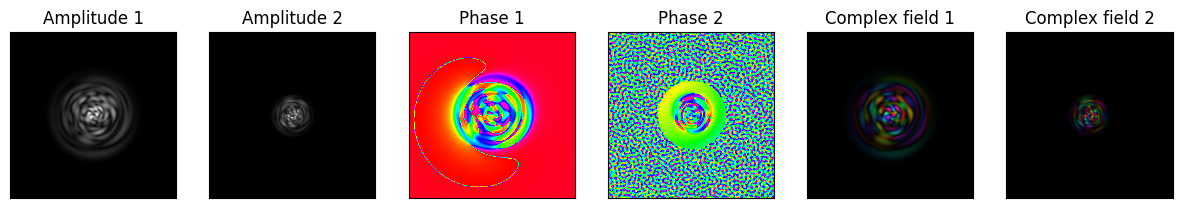

In [59]:
field = np.load('../imports/grin_speckle_example.npy')
# field = speckleret.transforms.pad_img(field, pad=0.5)
ft_field = speckleret.transforms.fourier_transform(field, pad=None)
_ = speckleret.plots.compare_complex_fields(field, ft_field, remove_ticks=True)

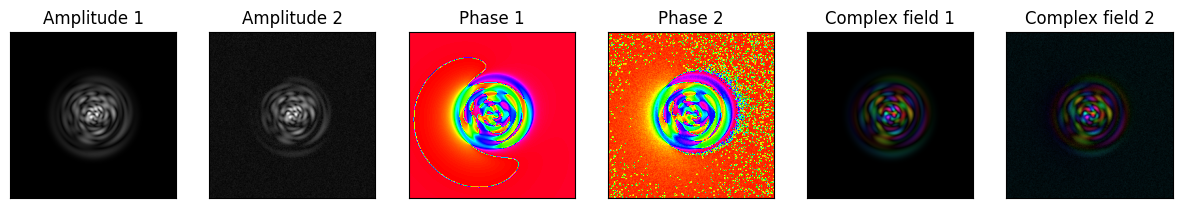

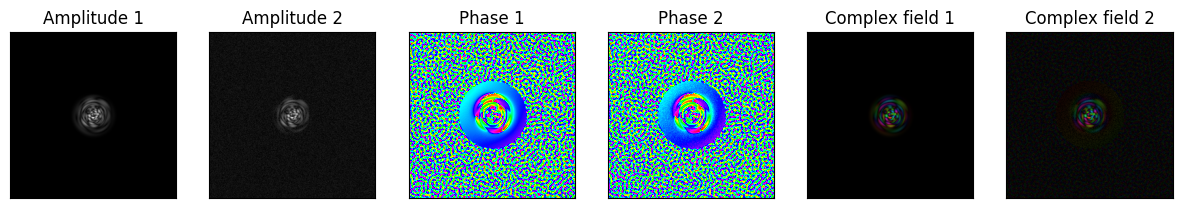

In [60]:
noisy_field = speckleret.noise.add_complex_noise(field, intens_noise_std=0.005, phase_noise_std=1064e-9/60, wavelength=1064e-9)
noisy_ft = speckleret.noise.add_complex_noise(ft_field, intens_noise_std=0.005, phase_noise_std=1064e-9/60, wavelength=1064e-9)

_ = speckleret.plots.compare_complex_fields(field, noisy_field, remove_ticks=True)
_ = speckleret.plots.compare_complex_fields(ft_field, noisy_ft, remove_ticks=True)

## Run phase retrieval on the computed fields

Let's first generate the support constraint from thresholding and visualize the support

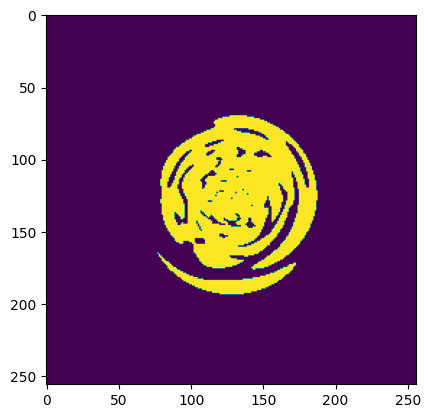

In [64]:
support = speckleret.supports.threshold_support(field, threshold=0.01)
plt.imshow(support)
plt.show()

# support = speckleret.supports.disk_support(field, radius=65)
# supported_field = field * support
# _ = speckleret.plots.complex_imshow(supported_field, remove_ticks=True)

## Run phase retrieval

Phase error:
  - Mean: 0.00530 rad
  - Std: 0.18816 rad
  - Lambda / X: 33.39326 rms


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

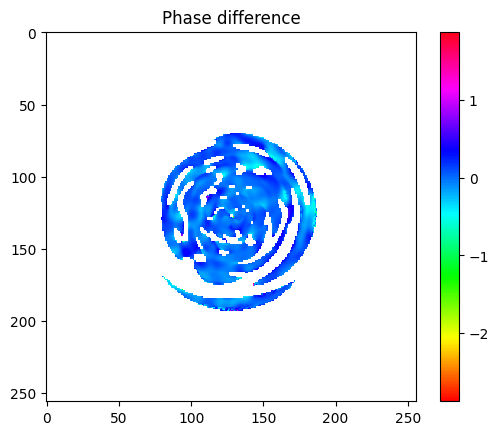

In [69]:
max_iter = 300
beta = 0.8

x = np.abs(field) * np.exp(1j * 2 * np.pi * np.random.rand(*field.shape))

mse = []
quality = []
for i in range(max_iter):
    metric = speckleret.metrics.mse(speckleret.transforms.fourier_transform(x), np.abs(ft_field))
    q = speckleret.metrics.quality(x[support], field[support], inversed=True)
    mse.append(metric)
    quality.append(q)

    # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.SF(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HIO(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.DM(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.ASR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support)
    # x = speckleret.retrievalmath.HPR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft), support=support, beta=beta)
    x = speckleret.retrievalmath.RAAR(x=x, magnitude_S=np.abs(field), magnitude_M=np.abs(ft_field), support=support, beta=beta)

    if i == 0:
        q_best, x_best = q, x
    else:
        if q < q_best:
            q_best, x_best = q, x
            
            
speckleret.plots.phase_difference(x_best, field, support)

Generate the support of the object field

Quality: 0.976948631811381
Pearson: 0.9630740145809178
Best Quality: 0.985132106930739
Best Pearson: 0.9632889112026626
Quality: 0.9414908231836912
Pearson: 0.9630740145809178
Best Quality: 0.9661864125483695
Best Pearson: 0.9632889112026626


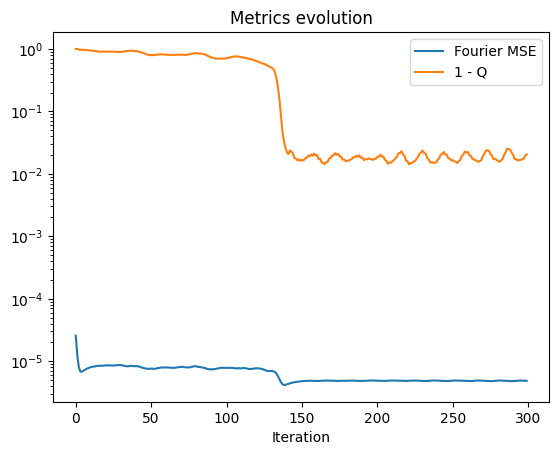

In [70]:
print(f"Quality: {speckleret.metrics.quality(x[support], field[support])}")
print(f"Pearson: {speckleret.metrics.pearson(x[support], field[support])}")
print(f"Best Quality: {speckleret.metrics.quality(x_best[support], field[support])}")
print(f"Best Pearson: {speckleret.metrics.pearson(x_best[support], field[support])}")
print(f"Quality: {speckleret.metrics.quality(np.exp(1j * np.angle(x[support])), np.exp(1j * np.angle(field[support])))}")
print(f"Pearson: {speckleret.metrics.pearson(x[support], field[support])}")
print(f"Best Quality: {speckleret.metrics.quality(np.exp(1j * np.angle(x_best[support])), np.exp(1j * np.angle(field[support])))}")
print(f"Best Pearson: {speckleret.metrics.pearson(x_best[support], field[support])}")

plt.figure()
plt.plot(mse, label='Fourier MSE')
plt.plot(quality, label='1 - Q')
plt.yscale('log')
plt.title('Metrics evolution')
plt.xlabel('Iteration')
plt.legend()